In [37]:
import warnings
warnings.filterwarnings('ignore')

import requests
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn import set_config; set_config(display='diagram')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV


import statsmodels.api as sm
import statsmodels.formula.api as smf

import shap

from pandas_profiling import ProfileReport

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2

# Train the model

In [4]:
# We train the model on passes from season 2021-2022 (and will make predictions on current season)
# Replace 'xxx' by your Wyscout API credentials

from Data_preparation import *

match_l1_2021 = get_match_ids('412', 187374, 'xxx')

df_pass_2021 = load_and_prepare_pass_data(match_l1_2021, 'xxx')

df_pass_2021 = change_column_type(df_pass)

In [ ]:
# Or if you saved the dataset as a pickle file

with open("pass_data_2021.pkl", "rb") as input_file:
    df_pass_2021 = pickle.load(input_file)

In [5]:
# We remove columns that are not useful for the model but that will be used as analyses breakdowns

df_pass_2021 = df_pass_2021.drop(columns=['match_id', 'match_period', 'minute', 'team', 'opponent_team', 'player', 'result'])

In [3]:
num_transformer = Pipeline([('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['float64', 'int64']))],
    remainder='passthrough')

In [4]:
# We keep the best hyperparameters found with Grid Search CV below

final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('lr', LogisticRegression(class_weight={0:85, 1:15}))])
final_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9b758bf190>)])),
                ('lr', LogisticRegression(class_weight={0: 85, 1: 15}))])

In [22]:
X = df_pass_2021.drop(columns=['result'])
y = df_pass_2021[['result']]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [24]:
final_pipe = final_pipe.fit(X_train, y_train)

In [25]:
y_pred = final_pipe.predict(X_test)

In [26]:
accuracy_score(y_test, y_pred)

0.8067231803566208

In [27]:
precision_score(y_test, y_pred)

0.9501971196395527

In [28]:
recall_score(y_test, y_pred)

0.8146513071670001

In [29]:
f1_score(y_test, y_pred)

0.8772190447894229

In [30]:
y_prob = final_pipe.predict_proba(X_test)

In [31]:
y_prob.shape

(17105, 2)

# Confusion Matrix / AUC-ROC curve / PR curve

In [32]:
%matplotlib inline

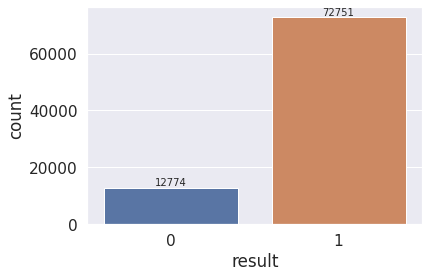

In [57]:
ax = sns.countplot(y.result)

for i in ax.containers:
    ax.bar_label(i,size=10)

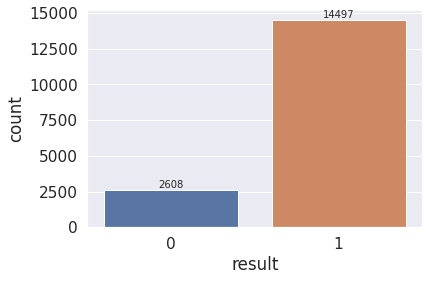

In [58]:
ax = sns.countplot(y_test.result)

for i in ax.containers:
    ax.bar_label(i,size=10)

In [5]:
# Since our dataset is imbalanced, we will not focus on accuracy 
# In our case, we do not want our model to be efficient only in predicting successful passes, but also failures as well
# Thus precision will be the main metric insted of recall

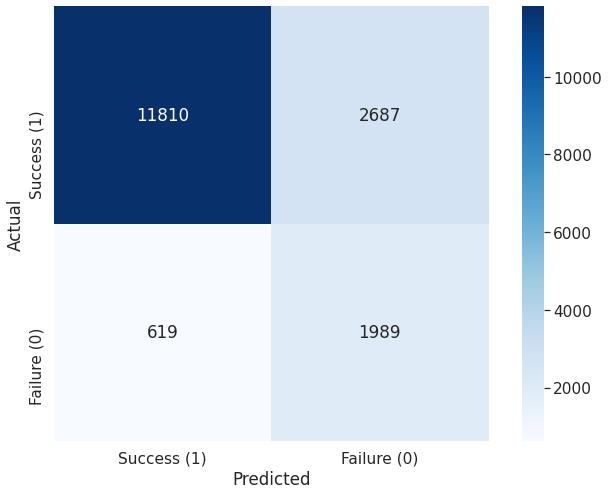

In [33]:
cfm = confusion_matrix(y_test.to_numpy(), y_pred)
plt.figure(figsize = (12,8))
sns.set(font_scale=1.4)
ax = sns.heatmap(cfm, cmap='Blues',annot=True, fmt='d', square=True,xticklabels=['Failure (0)', 'Success (1)'], yticklabels=['Failure (0)', 'Success (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()

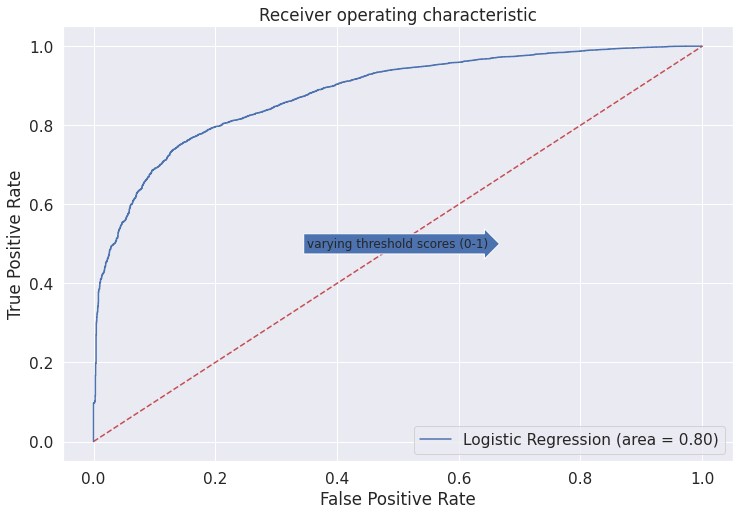

In [27]:
logit_roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1]) 
plt.figure(figsize = (12,8)) 
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--') 
plt.text(0.5, 0.5, "varying threshold scores (0-1)", rotation=0, size=12,ha="center", va="center",bbox=dict(boxstyle="rarrow"))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right") 
plt.savefig('Log_ROC') 
plt.show()

(0.0, 1.0)

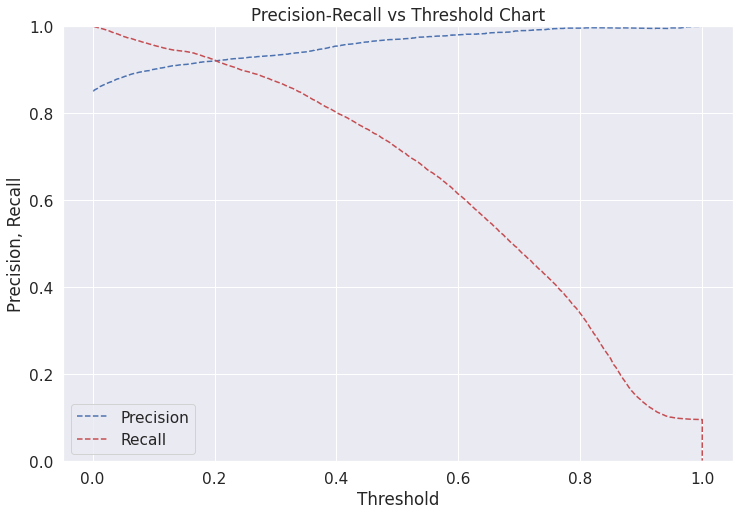

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:,1]) #retrieve probability of being 1(in second column of probs_y)
#pr_auc = metrics.auc(recall, precision)

plt.figure(figsize = (12,8))
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Text(0.5, 0, 'recall')

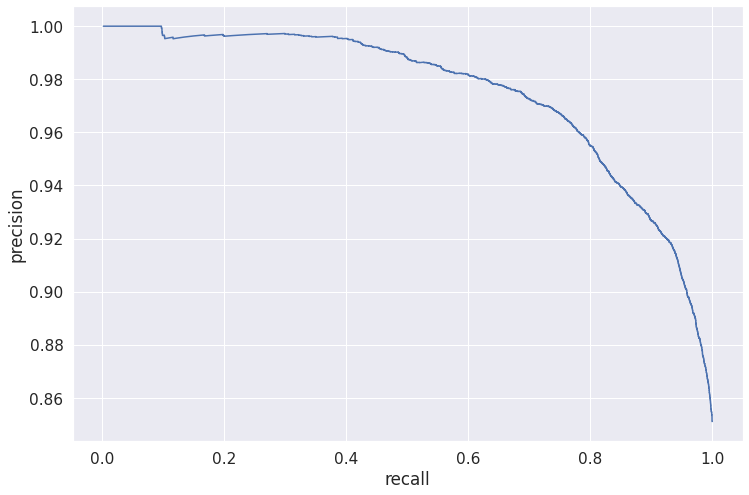

In [331]:
scores = pd.DataFrame({'threshold':thresholds,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})

plt.figure(figsize = (12,8))
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [332]:
# Find threshold that guarantees 0.8 recall score
scores[scores['recall'] >= 0.8].threshold.max()

0.4026284418581565

In [333]:
# Find threshold that guarantees 0.9 precision score
scores[scores['precision'] >= 0.9].threshold.min()

0.0964233770539018

In [35]:
y_prob_df = pd.DataFrame(y_prob)
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = y_prob_df[[1]].applymap(lambda x: 1 if x>i else 0)
    test_precision = precision_score(y_test, y_test_pred)
    #test_precision = precision_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1), y_pred.iloc[:,1].as_matrix().reshape(y_pred.iloc[:,1].as_matrix().size,1))
    print('Our testing precision is {}'.format(test_precision))

    #print(confusion_matrix(Y_test.as_matrix().reshape(Y_test.as_matrix().size,1), Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))


******** For i = 0.05 ******
Our testing precision is 0.8728700097370984

******** For i = 0.1 ******
Our testing precision is 0.8899602949517867

******** For i = 0.15 ******
Our testing precision is 0.9002716336825767

******** For i = 0.2 ******
Our testing precision is 0.9099927253488526

******** For i = 0.25 ******
Our testing precision is 0.9165209202206377

******** For i = 0.3 ******
Our testing precision is 0.9223593964334705

******** For i = 0.35 ******
Our testing precision is 0.9281073446327683

******** For i = 0.4 ******
Our testing precision is 0.9330760267987184

******** For i = 0.45 ******
Our testing precision is 0.9392930133979259

******** For i = 0.5 ******
Our testing precision is 0.9501971196395527

******** For i = 0.55 ******
Our testing precision is 0.9603052126200274

******** For i = 0.6 ******
Our testing precision is 0.9690322580645161

******** For i = 0.65 ******
Our testing precision is 0.9760064250577252

******** For i = 0.7 ******
Our testing pre

In [36]:
y_test_pred = y_prob_df[[1]].applymap(lambda x: 1 if x>0.6 else 0)

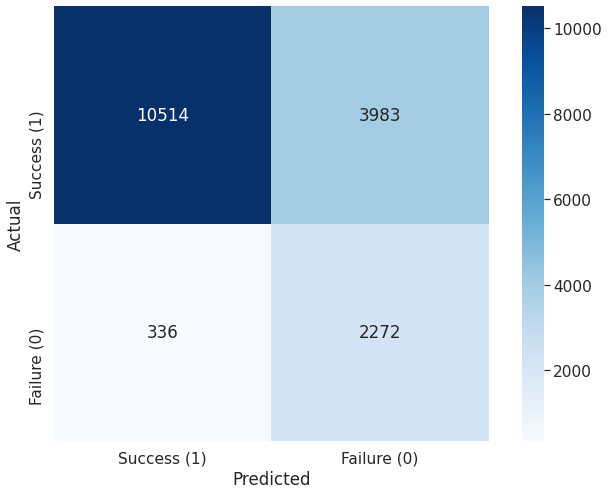

In [37]:
cfm_test = confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy())
plt.figure(figsize = (12,8))
sns.set(font_scale=1.4)
ax = sns.heatmap(cfm_test, cmap='Blues',annot=True, fmt='d', square=True,xticklabels=['Failure (0)', 'Success (1)'], yticklabels=['Failure (0)', 'Success (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()

# Tuning hyperparameters

In [293]:
final_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'lr', 'preprocessing__n_jobs', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__num_transformer', 'preprocessing__num_transformer__memory', 'preprocessing__num_transformer__steps', 'preprocessing__num_transformer__verbose', 'preprocessing__num_transformer__scaler', 'preprocessing__num_transformer__scaler__copy', 'preprocessing__num_transformer__scaler__feature_range', 'lr__C', 'lr__class_weight', 'lr__dual', 'lr__fit_intercept', 'lr__intercept_scaling', 'lr__l1_ratio', 'lr__max_iter', 'lr__multi_class', 'lr__n_jobs', 'lr__penalty', 'lr__random_state', 'lr__solver', 'lr__tol', 'lr__verbose', 'lr__warm_start'])

In [299]:
grid = {#'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'], 
        #'lr__penalty': ['none', 'l1', 'l2', 'elasticnet'],
        'lr__class_weight': ['balanced', {0:50, 1:50}, {0:60, 1:40}, {0:70, 1:30}, {0:80, 1:20}, {0:90, 1:10}]}

search = GridSearchCV(final_pipe, grid, 
                           scoring = 'precision',
                           cv = 5,
                           n_jobs=-1,# paralellize computation
                           verbose=1)

search.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_transformer',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f07a83f2ee0>)])),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__class_weight': ['balanced', {0: 50, 1: 50},
                                              {0: 60, 1: 40}, {0: 70, 1: 30},
                                              {0: 80, 1: 20}, {0: 90, 1: 10}]},
             scoring='precision', verbose=1)

In [300]:
search.best_score_

0.9683194247426267

In [301]:
search.best_params_

{'lr__class_weight': {0: 90, 1: 10}}

# Feature selection

In [38]:
pass_cor = df_pass_2021.corr() 
pass_cor

,x_start,y_start,previous_carry_progression,previous_action_teammate,angle,length,x_end,y_end,number_passes_possession,back_pass,...,previous_event_goal_kick,previous_event_interception,previous_event_pass,previous_event_shot_against,previous_event_throw_in,previous_event_touch,height_No,height_high,height_low,result
x_start,1.000000,0.019301,0.086499,0.125654,0.004802,-0.148898,0.768623,0.017893,0.210697,0.132025,...,-0.095534,-0.027366,-0.040390,-0.039198,0.023129,0.026065,-0.017399,-0.062462,0.190834,-0.119035
y_start,0.019301,1.000000,-0.005166,-0.001077,-0.379757,0.010126,0.023033,0.677369,0.008491,-0.009644,...,0.001458,0.004281,0.002230,-0.000110,-0.000555,-0.002858,-0.015588,0.010437,0.011791,-0.014422
previous_carry_progression,0.086499,-0.005166,1.000000,0.052216,-0.007072,0.007305,0.127507,-0.014314,-0.020080,-0.065317,...,-0.018217,-0.023674,-0.299454,-0.017563,-0.037044,0.487031,0.004259,-0.005479,0.006458,-0.018228
previous_action_teammate,0.125654,-0.001077,0.052216,1.000000,0.001405,0.007795,0.118466,0.002984,0.216760,-0.030005,...,-0.005701,-0.025319,0.148166,-0.322246,0.031715,0.008674,0.030141,-0.036588,0.013202,-0.045080
angle,0.004802,-0.379757,-0.007072,0.001405,1.000000,-0.041736,0.009057,0.170725,0.002576,0.062389,...,0.002373,-0.000954,0.000853,0.000126,-0.000413,-0.005891,0.017637,-0.007538,-0.009409,0.017824
length,-0.148898,0.010126,0.007305,0.007795,-0.041736,1.000000,0.072252,-0.007763,-0.019335,-0.149653,...,0.015502,-0.023446,0.039679,0.016028,-0.032759,0.011383,-0.495447,0.453825,0.014071,-0.174743
x_end,0.768623,0.023033,0.127507,0.118466,0.009057,0.072252,1.000000,0.045565,0.178096,-0.197091,...,-0.067637,-0.017065,-0.034827,-0.040601,-0.011969,0.053422,-0.262270,0.229803,0.163340,-0.250850
y_end,0.017893,0.677369,-0.014314,0.002984,0.170725,-0.007763,0.045565,1.000000,0.011491,-0.006425,...,0.004683,0.004247,0.005439,-0.003431,0.000495,-0.011643,-0.008779,0.007907,0.004348,-0.003724
number_passes_possession,0.210697,0.008491,-0.020080,0.216760,0.002576,-0.019335,0.178096,0.011491,1.000000,-0.009216,...,-0.081584,-0.084655,0.264165,-0.071979,-0.156279,-0.021922,0.044812,-0.058231,0.030702,0.002765
back_pass,0.132025,-0.009644,-0.065317,-0.030005,0.062389,-0.149653,-0.197091,-0.006425,-0.009216,1.000000,...,-0.021304,0.002885,-0.010030,0.059313,0.028665,-0.038089,0.138846,-0.130281,-0.030253,0.110410


<AxesSubplot:>

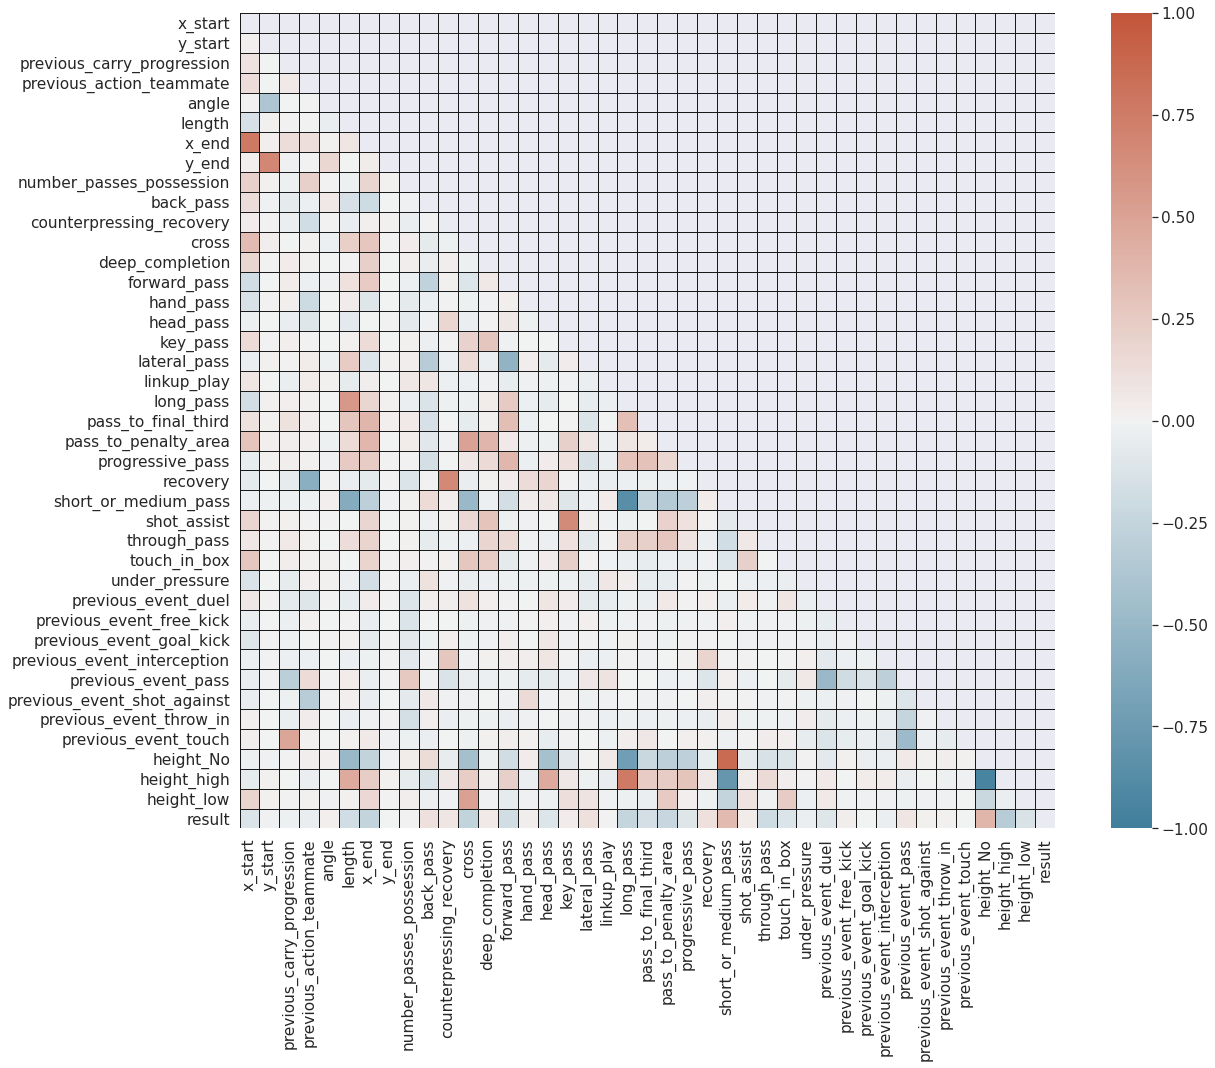

In [41]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(pass_cor, dtype=bool))

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(
    data=pass_cor,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=False, 
    fmt='.3f',
    ax=ax)

In [163]:
# Sequential Forward Selection(sfs) 
sfs = SFS(LogisticRegression(),
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring = 'accuracy', 
          cv = 0)

sfs.fit(X, y) 
sfs.k_feature_names_

('x_end',
 'back_pass',
 'carry',
 'cross',
 'deep_completed_cross',
 'deep_completion',
 'head_pass',
 'key_pass',
 'pass_to_final_third',
 'pass_to_penalty_area',
 'progressive_pass',
 'recovery',
 'shot_assist',
 'through_pass',
 'touch_in_box',
 'previous_event_touch')

In [176]:
len(sfs.k_feature_names_)

16

<Figure size 1440x720 with 0 Axes>

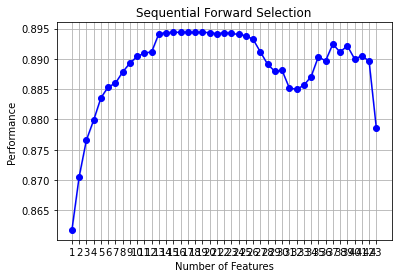

In [171]:
#fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.figure(figsize=(20,10))
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection') 
plt.grid()

In [174]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=20)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

20 selected features


In [175]:
chi_feature

['x_end',
 'back_pass',
 'carry',
 'cross',
 'forward_pass',
 'head_pass',
 'lateral_pass',
 'long_pass',
 'pass_to_final_third',
 'pass_to_penalty_area',
 'progressive_pass',
 'recovery',
 'short_or_medium_pass',
 'smart_pass',
 'through_pass',
 'touch_in_box',
 'previous_event_duel',
 'height_No',
 'height_high',
 'height_low']

# Statistical signifiance and learning curves

In [490]:
model_variables = list(passes_vf.columns)
model_variables.remove('result')
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]


#Fit the model
test_model = smf.glm(formula="result ~ " + model, data=passes_vf, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 result   No. Observations:                  901
Model:                            GLM   Df Residuals:                      849
Model Family:                Binomial   Df Model:                           51
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 04 Nov 2022   Deviance:                          nan
Time:                        10:15:12   Pearson chi2:                 1.58e+17
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [723]:
train_sizes, train_scores, test_scores = learning_curve(estimator=final_pipe, X=X_train, y=y_train, cv=10, train_sizes=np.linspace(0.1, 1.0, 10),n_jobs=1)

In [574]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

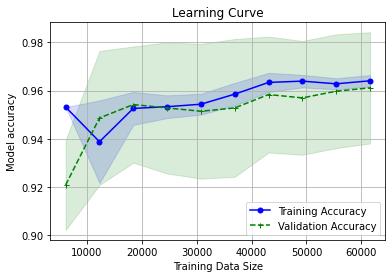

In [724]:
# Plot the learning curve
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Feature importance

In [42]:
# Fits the explainer
explainer = shap.Explainer(final_pipe.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 17106it [25:17, 11.23it/s]                           


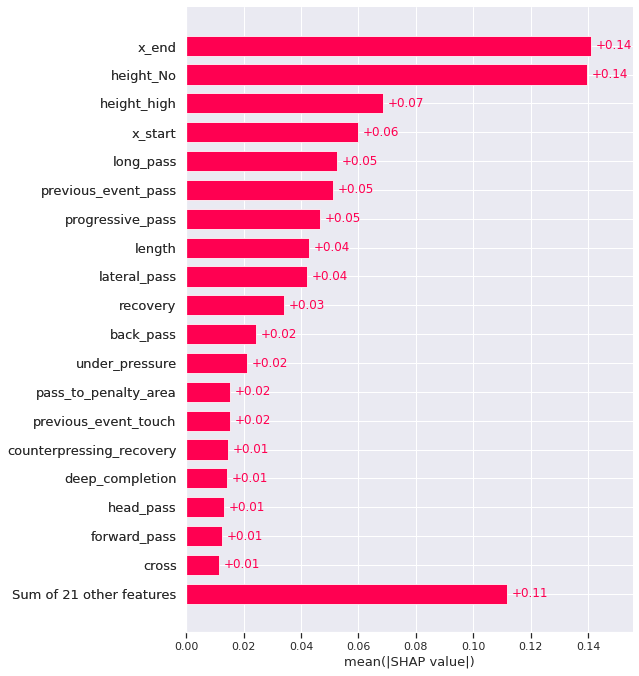

In [44]:
shap.plots.bar(shap_values, max_display=20)

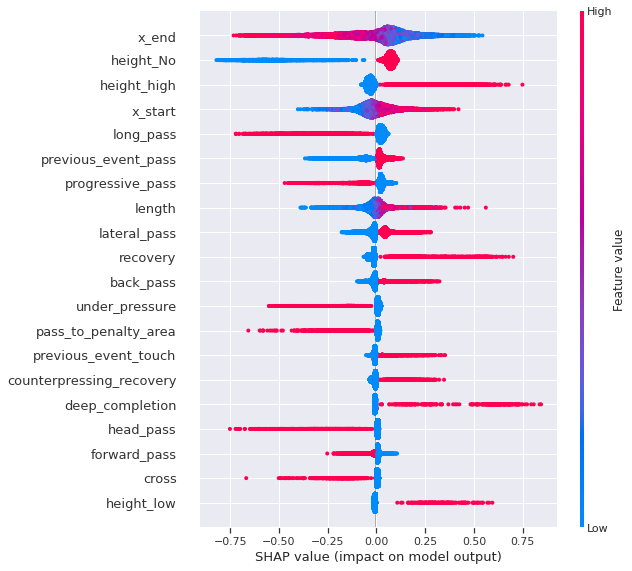

In [45]:
shap.summary_plot(shap_values)

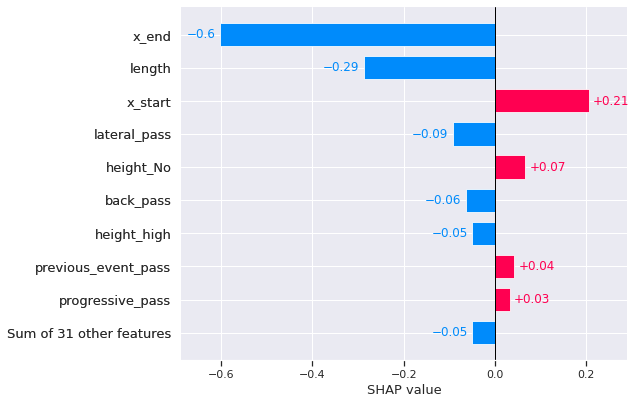

In [46]:
shap.plots.bar(shap_values[0])

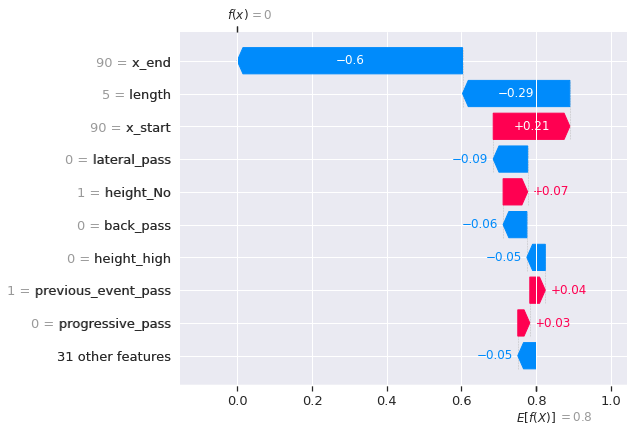

In [47]:
shap.plots.waterfall(shap_values[0])